# Dataset & Dataloader
* 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적
* `torch.utils.data.DataLoader`:  샘플에 쉽게 접근할 수 있도록 Dataset을 순회 가능한 객체 (iterable)로 감싼다.
* `torch.utils.data.Dataset`: 샘플과 정답(label) 저장

## pre-loaded 데이터셋 불러오기
* Fashion-MNIST
  * Zalando의 기사 이미지 데이터셋으로 60,000 개의 학습 예제와 10,000개의 테스트 예제로 이루어져 있다.
  * 각 예제는 흑백(grayscale)의 28 x 28 이미지와 10개 분류 (class) 중 하나인 정답(label)으로 구성됨.
* 다음 매개변수들을 사용하여 FashionMNIST 데이터셋을 불러온다.
  * `root`: 학습/테스트 데이터가 저장되는 경로
  * `train`: 학습용 또는 테스트용 데이터셋 여부를 지정
  * `download = True`: `root`에 데이터가 없는 경우 인터넷에서 다운로드
  * `transform`, `target_transform`: 특징(feature)과 label의 transform 지정


In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18835589.91it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 348455.90it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6282226.79it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16712288.69it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

## 데이터셋 순회 & 시각화

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

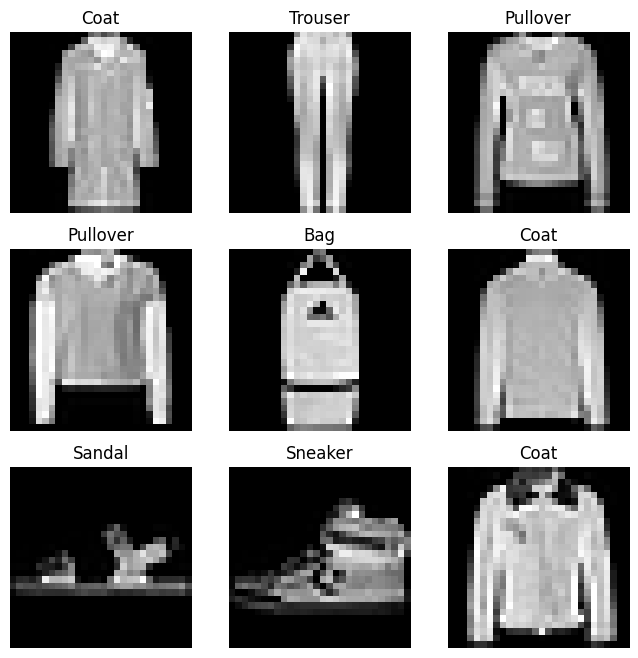

In [10]:
figure = plt.figure(figsize = (8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size = (1,)).item() # training length 중 랜덤한 수를 하나 가져오기, .item()은 텐서에서 값만을 가져온다.
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기
* 사용자 정의 Dataset 클래스는 반드시 3개의 함수를 구현해야 한다.
  * `__init__` : Dataset 객체가 생성될 때 한 번만 실행
  * `__len__`: 데이터셋의 샘플 개수를 반환
  * `__getitem__`: 주어진 인덱스 `idx`에 해당하는 샘플을 데이터셋에서 불러오고 반환


In [11]:
# FashionMNIST 이미지들은 `img_dir` 디렉토리에 저장
# 정답은 annotations_file csv 파일에 별도로 저장
import os
import pandas as pd
from torchvision.io import read_image

In [12]:
class CustonImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
    self.img_labels = pd.read_csv(annotations_file, names = ["file_name", "label"])
    self.img_dir = img_dir # 이미지와 주석 파일(annotation_file)이 포함된 디렉토리
    self.transform = transform # 변형 초기화
    self.target_transform = target_transform # 변형 초기화

  def __len__(self):
    return len(self.img_labels) # 데이터 샘플의 개수를 반환

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) # idx를 기반으로 디스크에서 이미지의 위치 식별
    image = read_image(img_path) # 이미지를 텐서로 변환
    label = self.img_labels.iloc[idx, 1] # csv 데이터로부터 해당하는 정답(label)을 가져오기
    if self.transform: # 해당하는 경우 변형 함수들 호출
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    sample = {"image": image, "label": label} # 텐서 이미지와 라벨을 dictionary 형태로 반환

    return sample

### 1. DataLoader로 학습용 데이터 준비
* `Dataset`: 데이터셋의 feature를 가져오고, 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다.
* 모델을 학습할 때, 일반적으로 샘플들을  
  1.  <<미니배치 (minibatch)>>로 전달하고,
  2. 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합 (overfit)을 막고,
  3. python의 `multiprocessing`을 사용해 데이터 검색 속도를 높여보자.
* `DataLoader`: 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체 (iterable).

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

### 2. DataLoader를 통해 순회하기 (iterate)
* `DataLoader`에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있다.
* 아래의 각 순회(iteration)(각각 `batch_size = 64`의 feature와 label을 포함하는) `train_features`와 `train_labels`의 묶음(batch)를 반환
* `shuffle = True`: 모든 배치를 순회한 뒤 데이터가 섞인다.
* 데이터 불러오기 순서를 보다 세밀하게 (finer-grained) 제어하려면 `Samplers` 참고

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


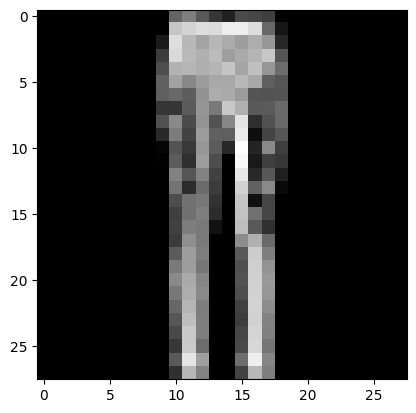

Label: 1


In [14]:
# 이미지와 label 표시
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap = "gray")
plt.show()
print(f"Label: {label}")